##06. PyTorch Transfer Learning

what is transfer learning?

Transfer learning invloves taking the parameters of what one model has learned on another dataset and applying to our own problem.

- Pretrained model = foundation models

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exist.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


Paths to our training and test directories

In [ ]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.Creating Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLodaders.

To do so, we can use `data-setup.py` and the `create_dataloaders()` function we made in `05.PyTorch Going Modular`.

There is one we have to think about when loading: how to transform it?

And with `torchvision` there are tow ways to do this:

 1. Manually created transforms- you define what transforms you want your data to go through
 2. Automatically created transforms- the transforms for your data are defined by the model you'd like use.

Imp Point: When using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual_creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right with `torchvision`.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].



In [ ]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.244, 0.255])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                 test_dir=test_dir,
                                                                                 transform=manual_transforms,
                                                                                 batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bd32378ae10>,
 ['pizza', 'steak', 'sushi'])

### Creating a transform for `torchvision.models (auto creation)

In [ ]:
# Get a set of pretrained model weigts
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloaders, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=auto_transforms,
                                                                                batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bd3237a2510>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get pretrained model such as:

 1. PyTorch domain libraires
 2. Libraries like `timm` (torch image models)
 3. HuggingFace Hub (for plenty of different models)
 4. Paperswithcode (for models across different problem spaces/domains)


### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

Thw Whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problems.

Three things to consider:
1. Speed
2. Size
3. Performance

Where does the model live?

Is it on deivce? (like a self driving car)

Or does it live on a server?

Which model should we choose?

For our case(deploying FoodVision Mini on a Mobile deivce), it looks like EffNetB0 is one of our best options in terms of performace and size.

However, in light of the Bitter Lesson, if we had an infinite compute we'll likely pick the biggest model + most parameters + most general we could- https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf

### 3.2 Setting up a pretrained model

Want to Create a Instance of a pretrained model EffNetB0

In [ ]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT"= best available model
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

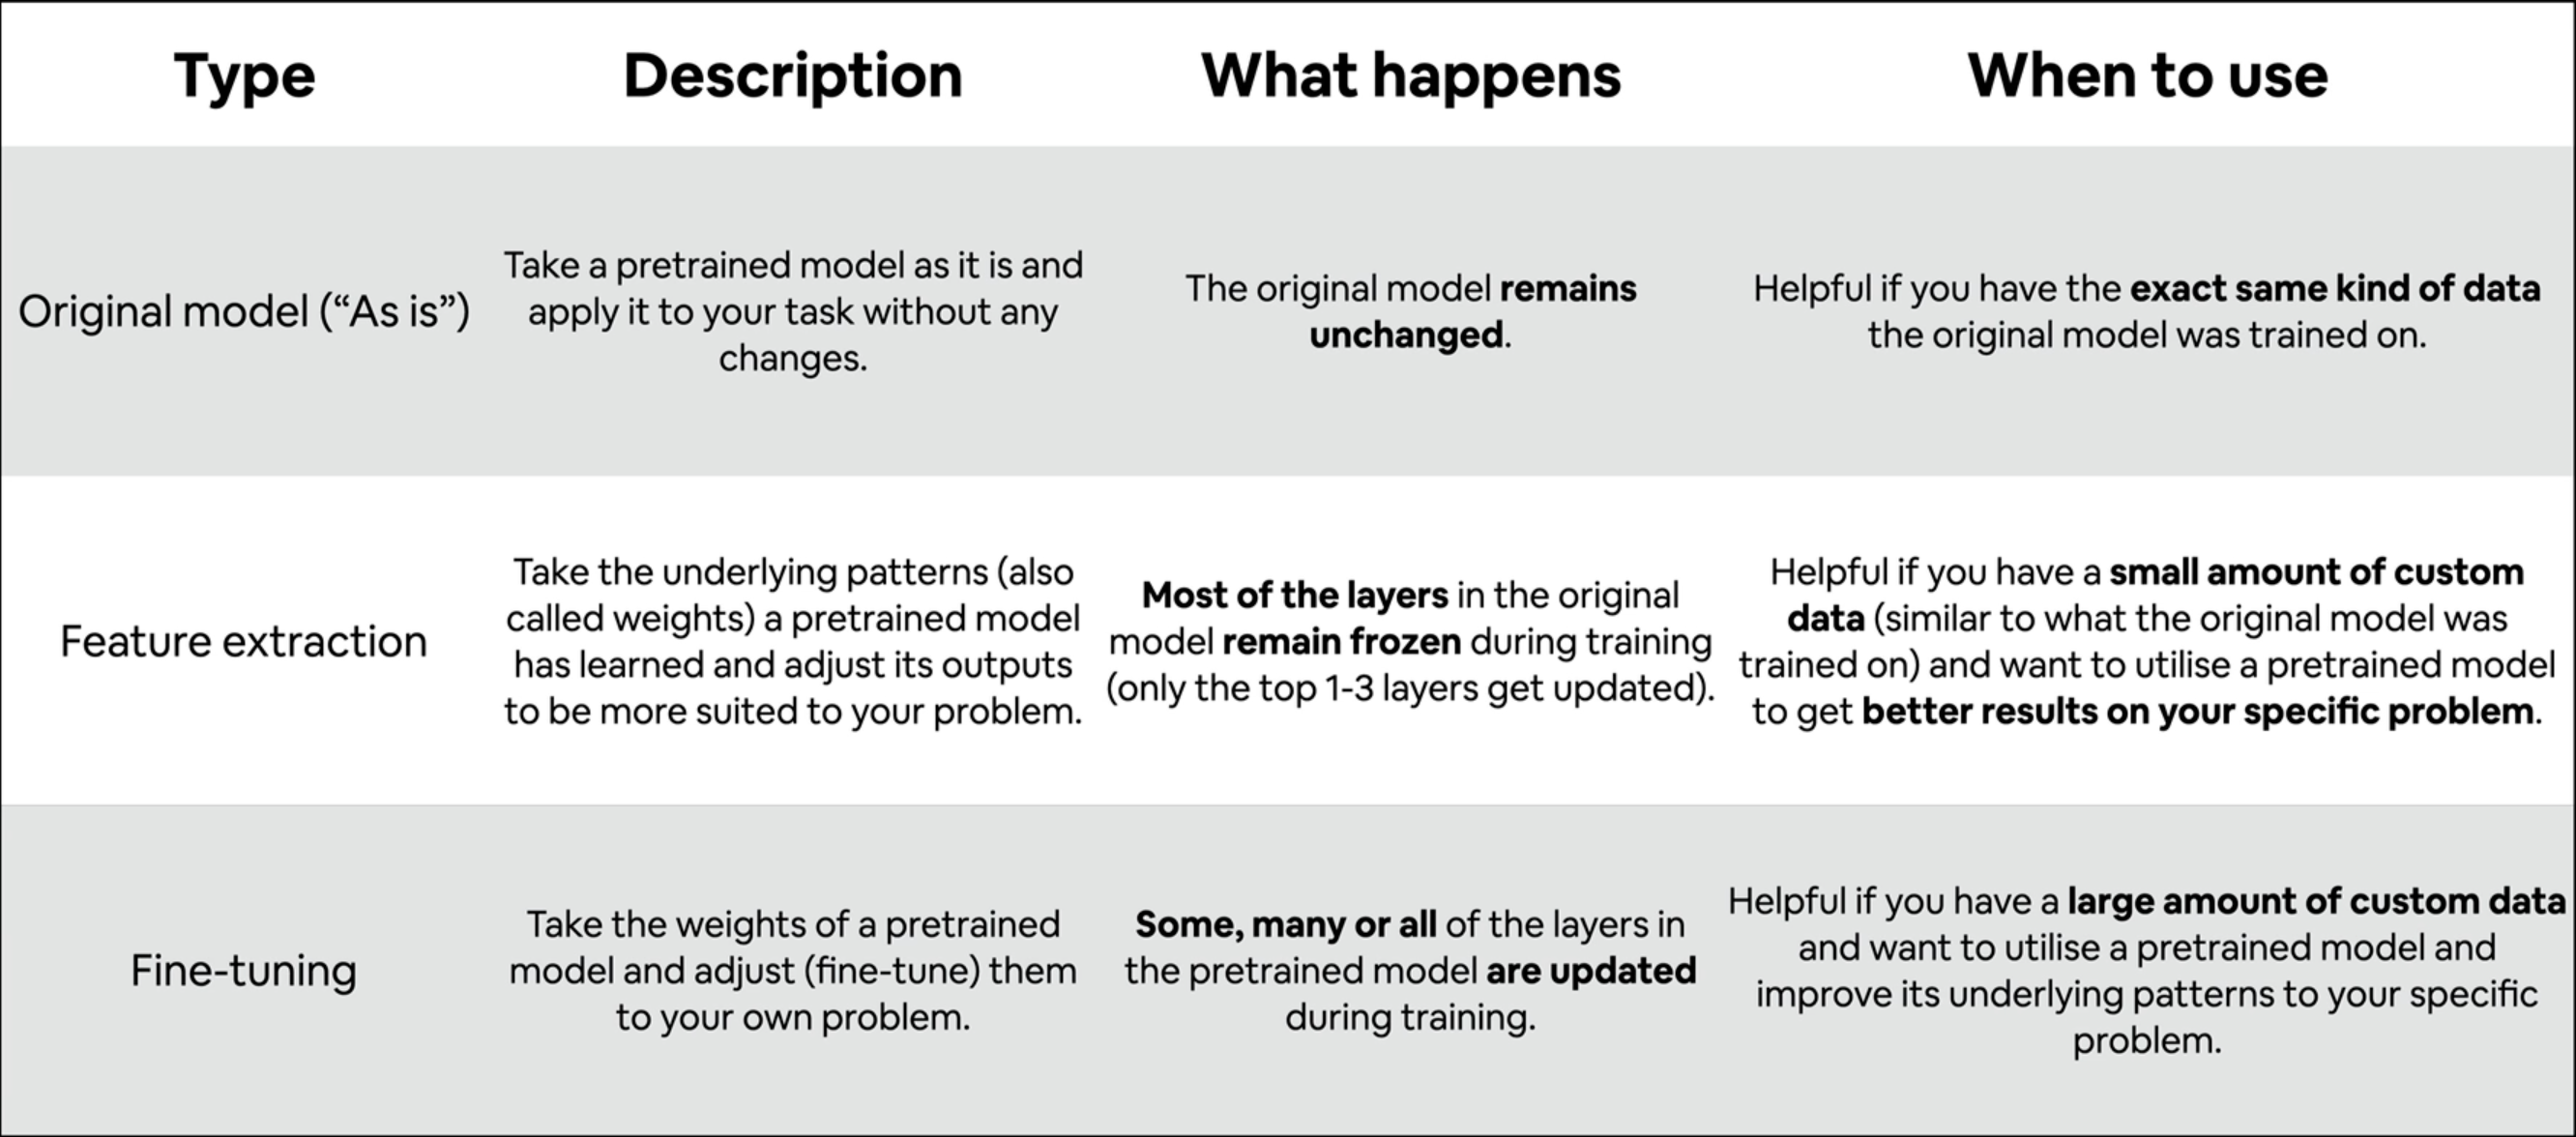

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), #example of [batch_size, colot_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [ ]:
### 3.4 Freeze all of the base layers on EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [ ]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,   # Features vector coming in
              out_features=len(class_names))).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224), #example of [batch_size, colot_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

##4. Train Model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9224 | test_acc: 0.5189
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.8088 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7672 | test_acc: 0.6610
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6548 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6411 | test_acc: 0.8759
[INFO] Total training time: 17.588 seconds


In [ ]:
results

{'train_loss': [1.0924270078539848,
  0.8716965168714523,
  0.7647949680685997,
  0.7108824849128723,
  0.6254763826727867],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9223713477452596,
  0.8087917963663737,
  0.7671960790952047,
  0.6548097928365072,
  0.641125480333964],
 'test_acc': [0.5189393939393939,
  0.7632575757575758,
  0.6609848484848485,
  0.8759469696969697,
  0.8759469696969697]}

##5. Evaluate model by plotting loss curves


[INFO] Couldn't find helper_functions.py, downloading...


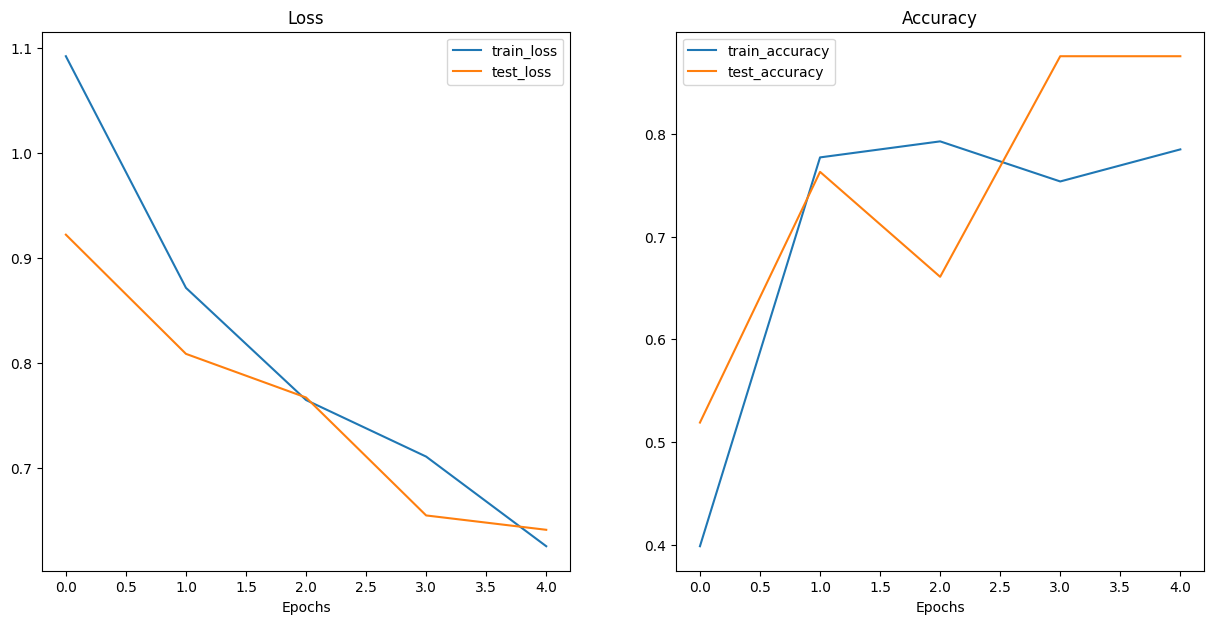

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

##6.1 Make Predictions on images from the test set

Visualize, visualize, visualize!

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

This means we'll need to make sure our images have:

 - Same shape - If our images are different shapes to what our model was trained on, we'll get shape errors.
 - Same datatype - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
 - Same device - If our images are on a different device to our model, we'll get device errors.
 - Same transformations - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

Note: These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function pred_and_plot_image() to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with PIL.Image.open().
3. Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from weights.transforms()).
4. Make sure the model is on the target device.
5. Turn on model eval mode with model.eval() (this turns off layers like nn.Dropout(), so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with torch.unsqueeze(dim=0) so our input image has shape [batch_size, color_channels, height, width].
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with torch.softmax().
9. Convert model's prediction probabilities to prediction labels with torch.argmax().
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8.

In [ ]:
from typing import List, Tuple

from PIL import Image

#1. Take in a trained model, class names, image path, image_size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn;t exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),

        ])

    ## Predict on Image ##

    # 4. Make sure the model is on target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image ([batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a  prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert predicition probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

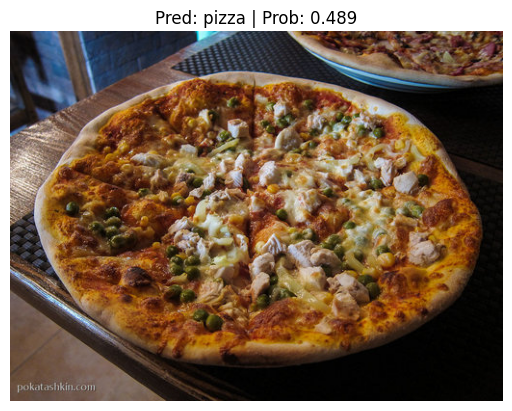

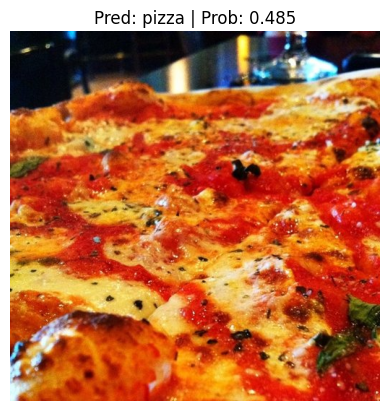

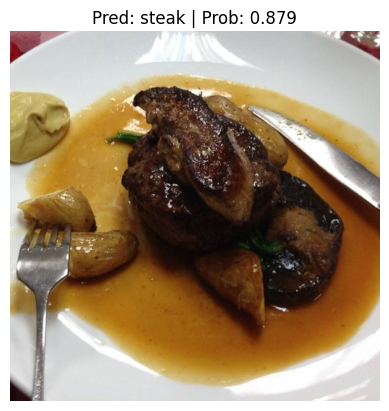

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list of all image paths form test data
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)


# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(), # optionally pass in a specified from our pretrained model weights
                        image_size=(32, 32),
                        )

###6.1 Making predictions on custom dataset


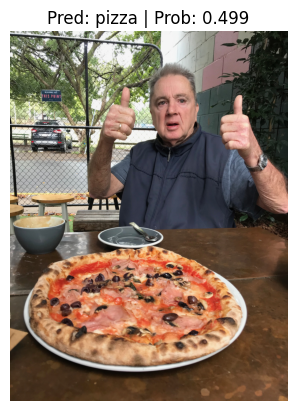

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

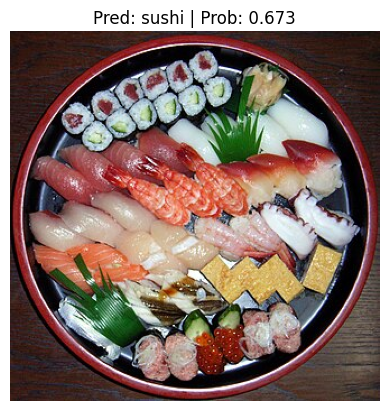

In [ ]:
# Predict on custom image
arr = ["/content/p3.jpeg", "/content/p4.jpeg", "/content/pizza.jpeg", "/content/pizza2.jpeg", "/content/ppp.jpg", "/content/s.webp", "/content/s1.jpg" ]
pred_and_plot_image(model=model,
                    image_path=arr[6],
                    class_names=class_names)

